# Salary Predictions Based on Job Descriptions

# DEFINE

### ---- Define the problem ----

Predicting Salary with the features factors Dataset
This notebook demonstrates the entire process of building a predictive model to suggest the salary range for job seekers. All the processes involving defining problems, discovering dataset, developing model, and deploying into production have been divided into main sections. Salary range tends to vary, depending on factors such as experiences, education, previous job title, etc. This predictive analysis aims to build a scalable and deployable model to predict salary used by Human Resource Department.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
# My information
__author__ = "Cho_Hang"
__email__ = "joench1993@gmail.com"

In [3]:
## helper function 

#load csv data files 
def load_file(file):
    return pd.read_csv(file)

#merge data
def merge_data(df1, df2, key):
    return df1.merge(df2, on = key)

#clean data function
def clean_data(df):
    #removes rows where salary equals to zero
    return df[df.salary > 0]

def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')

## DISCOVER

### ---- Load the data ----

In [4]:
!ls -lh data/

total 269304
-rwxr-xr-x@ 1 ngjo  staff    56M Oct  8  2016 test_features.csv
-rwxr-xr-x@ 1 ngjo  staff    56M Oct  8  2016 train_features.csv
-rwxr-xr-x@ 1 ngjo  staff    20M Oct  8  2016 train_salaries.csv


In [5]:
train_fea = load_file('data/train_features.csv')
train_salary = load_file('data/train_salaries.csv')
test_set = load_file('data/test_features.csv')

In [6]:
test_set.shape

(1000000, 8)

In [7]:
train_fea.shape

(1000000, 8)

In [8]:
train_salary.shape

(1000000, 2)

### ---- Inspect and clean the data ----

In [9]:
train_fea.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [10]:
train_salary.isnull().any()

jobId     False
salary    False
dtype: bool

In [11]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [12]:
train_fea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [13]:
train_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [14]:
# Merging the dataset train_salary and train_fea
train_merged = pd.merge(train_fea,train_salary, how='left', on='jobId')

In [15]:
# Look for duplicated values.
train_merged.duplicated().any()

False

In [16]:
#define variables
categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
numeric_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'

After some preprocessing and dataset, the merged training dataset looks clean.

### ---- Explore the data (EDA) ----

In [17]:
train_merged.shape

(1000000, 9)

In [18]:
train_merged.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [19]:
#review the summary statistics of the new merged dataset
train_merged.describe(include = 'all')

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000.000000,1000000.000000
unique,1000000,63,8,5,9,7,NaN,NaN,NaN
top,JOB1362685275668,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB,NaN,NaN,NaN
freq,1,16193,125886,236976,532355,143206,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,11.992386,49.529260,116.061818
std,NaN,NaN,NaN,NaN,NaN,NaN,7.212391,28.877733,38.717936
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,25.000000,88.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,50.000000,114.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,75.000000,141.000000


In [20]:
# Check if every record are unique
train_merged.jobId.nunique() == len(train_merged)

True

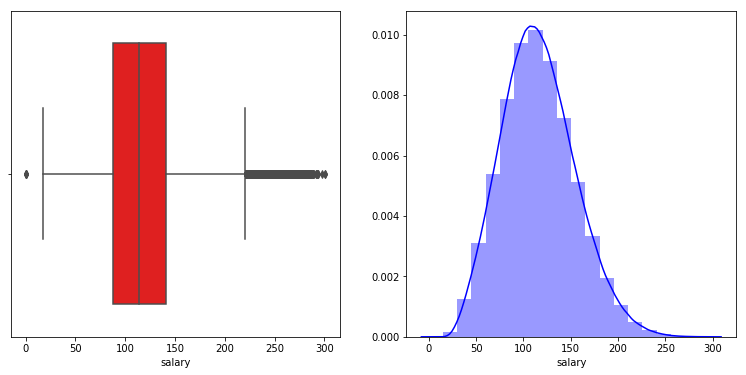

In [21]:
# Check the distribution of the target variable. 
plt.figure(figsize = (13, 6))
plt.subplot(1,2,1)
sns.boxplot(train_merged.salary,color = 'r')
plt.subplot(1,2,2)
sns.distplot(train_merged.salary, bins=20,color = 'b')
plt.show()

In [22]:
# Draw 10% sample from the original dataset for fasting training and ensure a more normally distributed target variable
train_subset = train_merged.sample(n=100000,replace = True)

In [23]:
train_subset.salary.describe()

count    100000.000000
mean        116.054450
std          38.878305
min          18.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         293.000000
Name: salary, dtype: float64

In [24]:
def plot_feature(df, col):
    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df.sort_values('salary'))
    
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')
    plt.show()

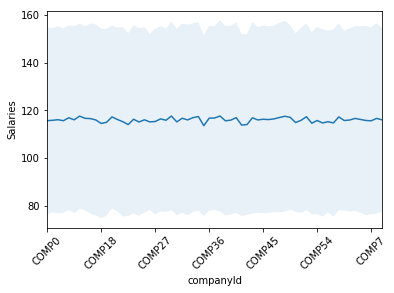

In [25]:
plot_feature(train_subset,'companyId')

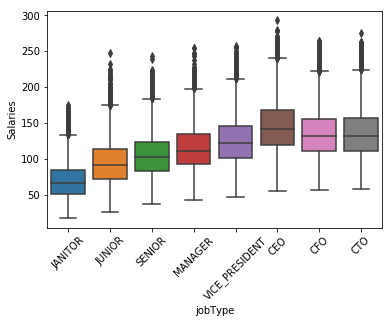

In [26]:
plot_feature(train_subset,'jobType')

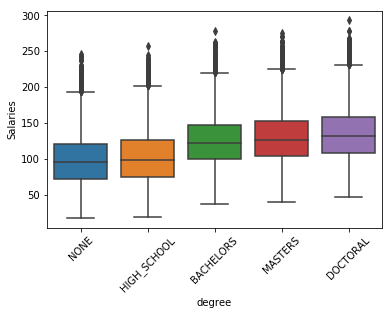

In [27]:
plot_feature(train_subset,'degree')

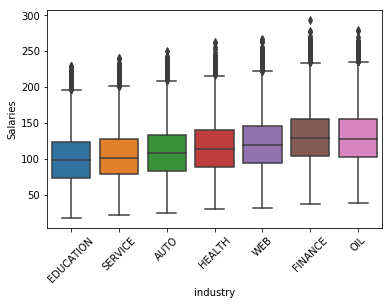

In [28]:
plot_feature(train_subset,'industry')

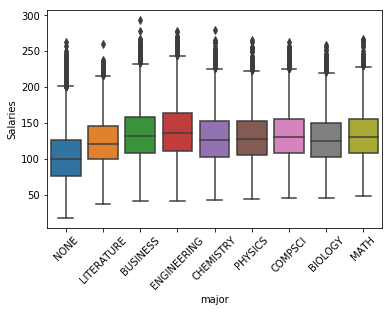

In [29]:
plot_feature(train_subset,'major')

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.001555,0.372710
milesFromMetropolis,0.001555,1.000000,-0.297638
salary,0.372710,-0.297638,1.000000


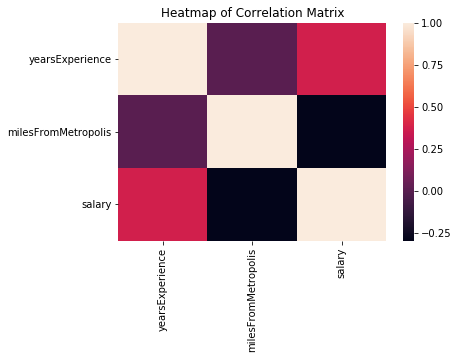

In [30]:
#look for correlation between each feature and the target
corr = train_subset.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

Text(0, 0.5, 'Count')

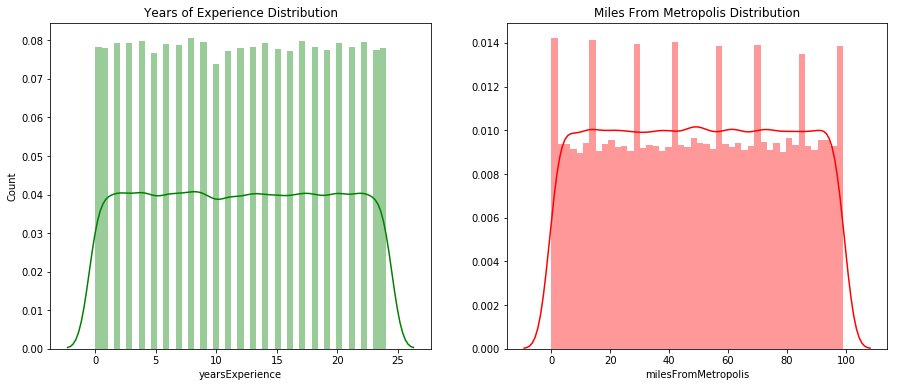

In [31]:
# Check distribution for years of experience
f, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.distplot(train_subset.yearsExperience, color="g", ax=axes[0]).set_title('Years of Experience Distribution')
axes[0].set_ylabel('Count')

sns.distplot(train_subset.milesFromMetropolis, color="r", ax=axes[1]).set_title('Miles From Metropolis Distribution')
axes[0].set_ylabel('Count')


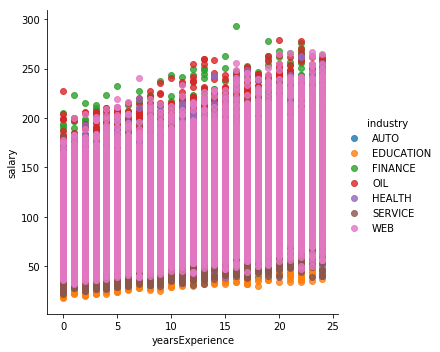

In [32]:
sns.lmplot(x='yearsExperience', y='salary', data=train_subset,
           fit_reg=False, # No regression line
           hue='industry')   

In [33]:
## Convert object to numerical for models prediction

le = preprocessing.LabelEncoder()
for item in train_subset:
        if train_subset[item].dtype == object:
            train_subset[item] = le.fit_transform(train_subset[item])
        else:
            pass
for item in test_set:
        if test_set[item].dtype == object:
            test_set[item] = le.fit_transform(test_set[item])
        else:
            pass


### ---- Establish a baseline (Linear Regression)----

In [34]:
# The following script divides data into attributes and labels:
X = train_subset.drop(['jobId','salary'],axis=1)
y = train_subset['salary']

In [35]:
# Split into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [36]:
# Training the Algorithm using linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
# Prediction
y_pred = lr.predict(X_test) 
y_pred

array([119.87504056, 120.27464445, 132.41662877, ..., 120.74219514,
       124.84448843, 112.54870676])

In [37]:
# Mean square error will be used to define my model performance
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

Mean Squared Error: 922.5666789639097


### ---- 6 Hypothesize solution ----

The mean square error for the baseline model is 907, Let try to use random forest and gradient boosting algorithms to see if it will improve the MSE. 

## DEVELOP

### ---- Create models ---- 

#### Building Random Forest Model 

In [51]:
model_1 = RandomForestRegressor(n_jobs = -1,oob_score=True, random_state=40)
# Fiting data
model_1.fit(X_train,y_train)
# Prediction
y_pred1 = model_1.predict(X_test) 
y_pred1

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


array([ 94.9, 100.2, 110.9, ...,  57.9,  44.7,  99. ])

In [52]:

print('Mean Squared Error:', mean_squared_error(y_test, y_pred1))

Mean Squared Error: 432.63391538888885


### Tuning Random Forest Model

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 depth
MSE Train:  288.5221180555556
MSE Test:  787.9206958333334
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 depth
MSE Train:  131.59381367009954
MSE Test:  520.8940659722223
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 depth
MSE Train:  99.86321538556125
MSE Test:  465.6436463611111
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10 depth
MSE Train:  76.30539761786352
MSE Test:  428.0554095177777
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


20 depth
MSE Train:  64.66923246485419
MSE Test:  409.1437850110884
 


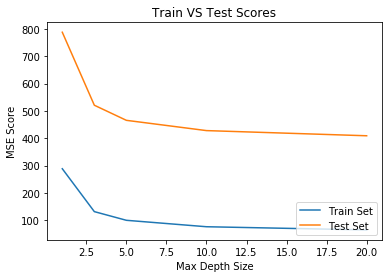

In [53]:
# Tuning max_depth_size
results  = []
results2 = []
max_depth_size  = [1,3,5,10,20]

for depth in max_depth_size:
    model = RandomForestRegressor(depth,n_jobs =-1 ,oob_score=True, random_state=44)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(depth, 'depth')
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    mse1 = mean_squared_error(y_train, pred)
    mse2 = mean_squared_error(y_test, pred2)
    print('MSE Train: ', mse1)
    print('MSE Test: ', mse2)
    results.append(mse1)
    results2.append(mse2)
    print (" ")

plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('MSE Score')
plt.title('Train VS Test Scores')
plt.legend(loc="lower right")
plt.show()

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 trees
AUC:  -5.554459926493618
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 trees
AUC:  -1.9089399644542988
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 trees
AUC:  -0.4001341088054158
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


15 trees
AUC:  0.6682649015821365
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


20 trees
AUC:  0.6933322957907728
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


25 trees
AUC:  0.7043395552727982
 
40 trees
AUC:  0.7174812449796939
 
50 trees
AUC:  0.7217977124401107
 
70 trees
AUC:  0.7260018051673542
 
100 trees
AUC:  0.7290283664229995
 


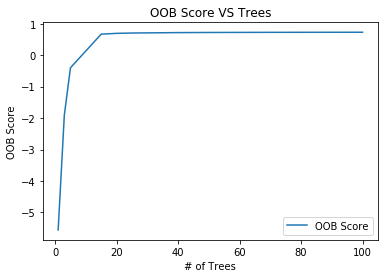

In [44]:
results = []
n_estimator_options = [1, 3, 5, 15, 20, 25, 40, 50, 70, 100]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, random_state=42)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(trees, 'trees')
    AUC = model.oob_score_
    print('AUC: ', AUC)
    results.append(AUC)
    print (" ")
    
plt.plot(n_estimator_options, results, label='OOB Score')
plt.xlabel('# of Trees')
plt.ylabel('OOB Score')
plt.title('OOB Score VS Trees')
plt.legend(loc="lower right")
plt.show()

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 min samples
AUC:  0.7043395552727982
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 min samples
AUC:  0.7172887127272364
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 min samples
AUC:  0.7228378157192384
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


7 min samples
AUC:  0.7253335765401847
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


9 min samples
AUC:  0.7263601181973499
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10 min samples
AUC:  0.7265654404425292
 
20 min samples
AUC:  0.7248636011898044
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


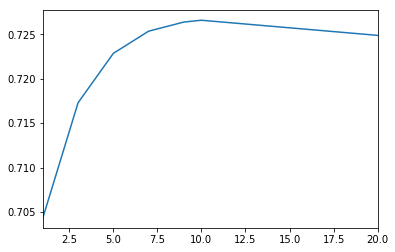

In [45]:
results_min_samples = []
min_samples_leaf_options = [1, 3, 5, 7, 9, 10, 20]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=25, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=min_samples)
    model.fit(X_train, y_train)
    print(min_samples, "min samples")
    auc = model.oob_score_
    print('AUC: ', auc)
    results_min_samples.append(auc)
    print (" ")
    
pd.Series(results_min_samples, min_samples_leaf_options).plot()


#### Rebuild Random Forest with the updated parameters

In [46]:
model_2 = RandomForestRegressor(n_jobs = -1,oob_score=True, random_state=40,n_estimators=25, max_depth=25,min_samples_leaf =10)
model_2.fit(X_train,y_train)
y_pred2 = model_2.predict(X_test) 
print('Mean Squared Error:', mean_squared_error(y_test, y_pred2))

Mean Squared Error: 399.927496670181


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#### Tuning Gradient Boosting 

In [47]:
results_depth=[]
for depth in [2,3,4,5,10]:
    clf = GradientBoostingRegressor(max_depth=depth)
    clf.fit(X_train, y_train)
    results_depth.append(
        {
            'max_depth': depth,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })
    
# Display Results
max_depth_lr = pd.DataFrame(results_depth).set_index('max_depth').sort_index()
max_depth_lr

,test_error,train_error
max_depth,,
2,430.756044,423.039492
3,392.674413,384.848311
4,375.590735,364.077715
5,367.625346,351.249600
10,373.548292,188.662696


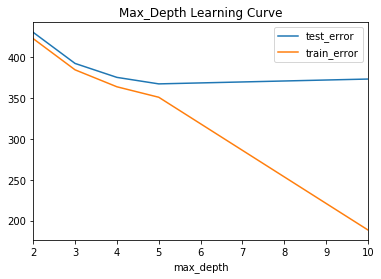

In [48]:
max_depth_lr.plot(title="Max_Depth Learning Curve")

In [49]:
results_learning=[]
for rate in [0.1,0.15,0.2,0.25,0.3]:
    clf = GradientBoostingRegressor(learning_rate=rate)
    clf.fit(X_train, y_train)
    results_learning.append(
        {
            'learning_rate': rate,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })
    
# Display Results
learning_rate_lr = pd.DataFrame(results_learning).set_index('learning_rate').sort_index()
learning_rate_lr

,test_error,train_error
learning_rate,,
0.10,392.674413,384.848311
0.15,377.837507,369.082085
0.20,374.777195,365.290556
0.25,372.915032,363.567048
0.30,371.077244,361.545219


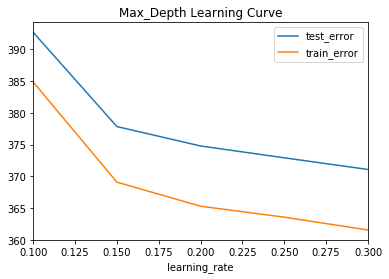

In [50]:
learning_rate_lr.plot(title="Max_Depth Learning Curve")

#### Building Gradient Boosting Model with the updated parameters

In [61]:
gbrt = GradientBoostingRegressor(max_depth=5, n_estimators=150,loss='ls',learning_rate=0.2,random_state=5)
gbrt.fit(X_train,y_train)
# Prediction
y_pred_3 = gbrt.predict(X_test) 
y_pred_3

array([ 86.12445538,  87.52398281, 104.73605822, ...,  64.04103072,
        43.98867442, 121.06891457])

In [62]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_3))

Mean Squared Error: 358.7789286289978


### ----  5-Fold Cross Validation ----

In [38]:
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = 2


In [39]:
#create models -- hyperparameter tuning already done by hand for each model
lr_cv = LinearRegression()
rf_tuned = RandomForestRegressor(n_estimators=100, n_jobs=num_procs, max_depth=25,random_state=2)
gbm_tuned = GradientBoostingRegressor(n_estimators=150, max_depth=5,learning_rate = 0.2,random_state=3)
                      
models.extend([lr_cv, rf_tuned, gbm_tuned])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, X, y, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Average MSE:
 938.1029441133514
Standard deviation during CV:
 2.7469520186775185

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=2, verbose=0, warm_start=False)
Average MSE:
 410.2405014493843
Standard deviation during CV:
 0.3102464259183364

Model:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_f

### ---- 10 Select best model  ----

In [40]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null int64
companyId              1000000 non-null int64
jobType                1000000 non-null int64
degree                 1000000 non-null int64
major                  1000000 non-null int64
industry               1000000 non-null int64
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(8)
memory usage: 61.0 MB


In [41]:
#choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print_summary(model, mean_mse, cv_std)

#train model on entire dataset
model.fit(X, y)
test_set = test_set.drop(['jobId'],axis=1)
#create predictions based on test data
predictions = model.predict(test_set)



Predictions calculated using model with lowest MSE:

Model:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=150, n_iter_no_change=None, presort='auto',
             random_state=3, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
Average MSE:
 366.35235171370505
Standard deviation during CV:
 0.0800417922953045


## DEPLOY

### ---- Automate pipeline ----

In [68]:
#write script that trains model on entire training set, saves model to disk, and scores the "test" dataset
def salary_prediction_pipeline(train_df, train_target, test_df):
    
    #load data
    print('Loading data...')
    train_df = load_file(train_df)
    train_target = load_file(train_target)
    test_df = load_file(test_df)
    
    #define variables
    categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
    numeric_vars = ['yearsExperience', 'milesFromMetropolis']
    target_var = 'salary'
    
    #merge data
    print('Merging data...')
    merged_df = merge_data(train_df, train_target, 'jobId')
    
    #clean data
    print('Cleaning data...')
    train_cleaned = clean_data(merged_df)
    
    #convert categorical variables to numerical for model building
    print('Converting data...')
    le = preprocessing.LabelEncoder()
    for item in merged_df:
            if merged_df[item].dtype == object:
                merged_df[item] = le.fit_transform(merged_df[item])
            else:
                pass
    for item in test_df:
            if test_df[item].dtype == object:
                test_df[item] = le.fit_transform(test_df[item])
            else:
                pass

    
    #initialize model list and dicts
    train = merged_df.drop(['jobId','salary'],axis=1)
    target = merged_df['salary']
    test_df = test_df.drop(['jobId'],axis=1)
    models = []
    mean_mse = {}
    cv_std = {}
    res = {}

    #define number of processes to run in parallel
    num_procs = 2
    
    #initialize tuned models
    print('Initializing models...')
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=100, n_jobs=num_procs, max_depth=5)
    gbm = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls',learning_rate = 0.2)
    models.extend([lr, rf, gbm])

    #parallel cross-validate models, using MSE as evaluation metric, and print summaries
    print("Cross validation...")
    for model in models:
        train_model(model, train, target, num_procs, mean_mse, cv_std)
        print_summary(model, mean_mse, cv_std)
    
    #train model on entire dataset
    print("Training model...")
    model.fit(train, target)

    #create predictions based on test data
    print("Prediction...")
    predictions = model.predict(test_df)
    
    #set index to 'feature'
    print("feature importance plotting...")
    rf.fit(test_df,target)
    feature_importances = pd.Series(rf.feature_importances_, index=test_df.columns)
    print(feature_importances)
    feature_importances.sort_values(inplace=True)
    feature_importances.plot(kind='barh', figsize=(7,6))
    

    #save results
    save_results(model, mean_mse[model], predictions, feature_importances)
    
    
    

### ---- Deploy solution ----

In [ ]:
salary_prediction_pipeline("data/train_features.csv", "data/train_salaries.csv", "data/test_features.csv")

Loading data...
Merging data...
Cleaning data...
Converting data...
Initializing models...
Cross validation...

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Average MSE:
 925.1823467790898
Standard deviation during CV:
 1.9225477805976539

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Average MSE:
 636.6888283473207
Standard deviation during CV:
 6.693524640045439


### ---- Summary ----

Overall, Gradient Boosting gives me the best model prediction performance based on MSE, which improves from over 907 in the baseline model to 360 on the train data. Features importance tells me that miles from Metropolis would be a top relevant feature in prediction. This model could be improved on diving into the statistical analysis checking how certain features are related to each others. Inituiively, engineering major might be more positively correlated with salary in the technology industry and finace major could be more important in the finance industry. Further feature engineering can be done to improve the model. 